# Advanced Usage - PBMC + IFNb in sample scenario

In this tutorial we'll be using pyroma to capture sample level variations in the perturbed setting. 
By querying predefined genesets, such as MSigDb Hallmarks, such approach highlights the largest sources of variance inside the dataset.
This could give insights into how such variance relates to the perturbed condition, cell types, cluster or other labels.  

In [ ]:
import os
import zipfile
import io
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.io
from glob import glob
import time

sc.set_figure_params(figsize=(3, 3), frameon=False )

#os.sys.path.append("/home/az/Downloads/pyroma_tutorial/pyroma/")

import pyroma
roma = pyroma.ROMA()
roma

scROMA

### load the PBMC dataset with IFNb stimulation from Kang et al. 2018
This is a good dataset for our purpose with clear expected biological response upon perturbation 

In [2]:
adata = pyroma.datasets.pbmc_ifnb()
adata

AnnData object with n_obs × n_vars = 13576 × 14053
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type'

subsmaple to reduce the computation cost

In [3]:
sc.pp.subsample(adata, n_obs=3000)

### standard preprocessing

In [4]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [5]:
adata

AnnData object with n_obs × n_vars = 3000 × 12158
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'n_genes'
    var: 'n_cells'
    uns: 'log1p'

### first look at the data

In [6]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

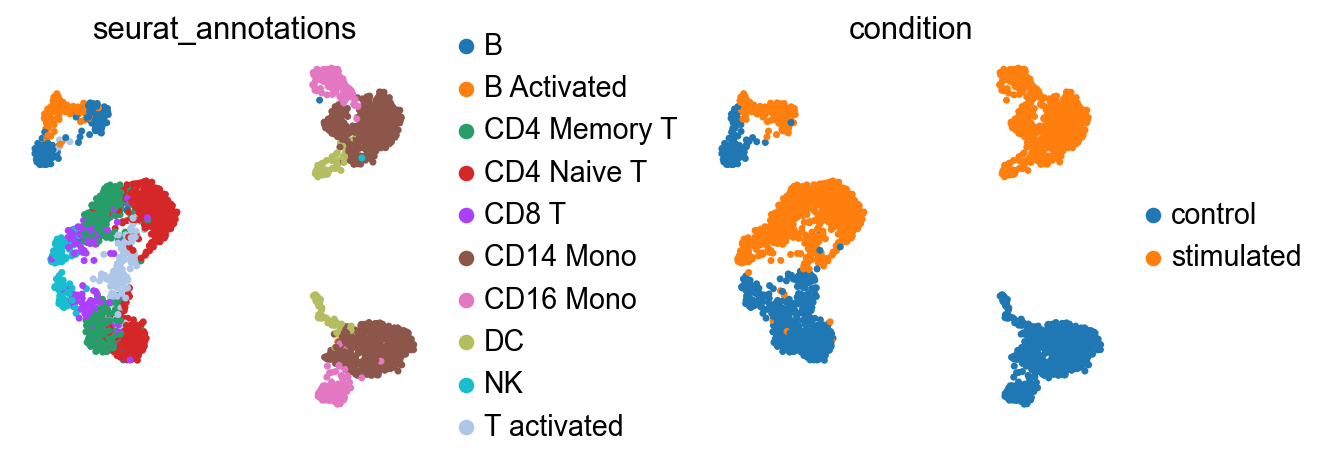

In [7]:
# "seurat_annotations" contain cell type information
# "condition" - is the IFNb stimulation category

sc.pl.umap(adata, color=['seurat_annotations', 'condition'],
           ncols=2,
           wspace=0.5)


### run pyroma

In [8]:
hallmarks_gmt_path = pyroma.genesets.use_hallmarks()

In [9]:
### change your output directory to store results

output_dir = "/home/az/Downloads/tutorial-test-results/02_pbmc_ifnb_sample/"
sample_name = "kang_sample_all"
roma.gmt = hallmarks_gmt_path

roma.adata = adata
roma.pc_sign_mode = 'UseMeanExpressionAllWeights'
pathways_to_check = 'all' 

iters = 100

start = time.time()
roma.compute(pathways_to_check, 
             parallel=True,
             loocv_on=True, 
             iters=iters,
            )

# save the results
roma.save_active_modules_results(os.path.join(output_dir,sample_name), only_active=False)

end = time.time()

minutes, seconds = divmod(end - start, 60)
print(f"CPU Parallel {iters} iterations for shape {adata.shape}, running time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))


Processing gene set: HALLMARK_NOTCH_SIGNALING | len of subsetlist: 27 
Processing gene set: HALLMARK_HEDGEHOG_SIGNALING | len of subsetlist: 17 
Processing gene set: HALLMARK_ANGIOGENESIS | len of subsetlist: 20 
Processing gene set: HALLMARK_PANCREAS_BETA_CELLS | len of subsetlist: 14 
Processing gene set: HALLMARK_WNT_BETA_CATENIN_SIGNALING | len of subsetlist: 33 
Processing gene set: HALLMARK_APICAL_SURFACE | len of subsetlist: 23 
Processing gene set: HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY | len of subsetlist: 46 
Processing gene set: HALLMARK_TGF_BETA_SIGNALING | len of subsetlist: 48 
Processing gene set: HALLMARK_MYC_TARGETS_V2 | len of subsetlist: 54 
Processing gene set: HALLMARK_CHOLESTEROL_HOMEOSTASIS | len of subsetlist: 61 
Processing gene set: HALLMARK_IL6_JAK_STAT3_SIGNALING | len of subsetlist: 74 
Processing gene set: HALLMARK_PROTEIN_SECRETION | len of subsetlist: 87 
Processing gene set: HALLMARK_INTERFERON_ALPHA_RESPONSE | len of subsetlist: 93 
Processing gene s

In [10]:
roma

scROMA: module activities are computed

In [11]:
roma.adata

AnnData object with n_obs × n_vars = 3000 × 12158
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'n_genes'
    var: 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'seurat_annotations_colors', 'condition_colors', 'ROMA_stats', 'ROMA_active_modules'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### all the pyroma statistics

In [12]:
roma.adata.uns['ROMA_stats']

,L1,ppv L1,Median Exp,ppv Med Exp,q L1,q Med Exp
HALLMARK_NOTCH_SIGNALING,0.383079,0.35,-0.032327,0.316832,0.729167,0.465929
HALLMARK_HEDGEHOG_SIGNALING,0.264958,0.63,0.014416,0.564356,0.926471,0.667741
HALLMARK_ANGIOGENESIS,0.793618,0.03,0.169210,0.009901,0.500000,0.030941
HALLMARK_PANCREAS_BETA_CELLS,0.302861,0.50,0.067470,0.089109,0.862069,0.143724
HALLMARK_WNT_BETA_CATENIN_SIGNALING,0.279624,0.58,0.058241,0.089109,0.926471,0.143724
HALLMARK_APICAL_SURFACE,0.365530,0.38,0.013935,0.574257,0.760000,0.667741
HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY,0.543208,0.15,0.105772,0.029703,0.500000,0.064572
HALLMARK_TGF_BETA_SIGNALING,0.152006,0.89,0.113007,0.009901,1.000000,0.030941
HALLMARK_MYC_TARGETS_V2,0.202604,0.68,0.833996,0.009901,0.937500,0.030941
HALLMARK_CHOLESTEROL_HOMEOSTASIS,0.412974,0.17,0.065308,0.029703,0.500000,0.064572


### active pathways

In [13]:
roma.adata.uns['ROMA_active_modules'].sort_values(by='Median Exp')

,L1,ppv L1,Median Exp,ppv Med Exp,q L1,q Med Exp
HALLMARK_OXIDATIVE_PHOSPHORYLATION,0.072015,0.98,-0.475797,0.009901,1.000000,0.030941
HALLMARK_DNA_REPAIR,0.090157,0.94,-0.142698,0.009901,1.000000,0.030941
HALLMARK_APOPTOSIS,0.278954,0.18,0.102191,0.009901,0.500000,0.030941
HALLMARK_TGF_BETA_SIGNALING,0.152006,0.89,0.113007,0.009901,1.000000,0.030941
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,0.435304,0.03,0.116284,0.009901,0.500000,0.030941
HALLMARK_E2F_TARGETS,0.064892,0.99,0.131956,0.009901,1.000000,0.030941
HALLMARK_UNFOLDED_PROTEIN_RESPONSE,0.275479,0.25,0.136769,0.009901,0.657895,0.030941
HALLMARK_ANGIOGENESIS,0.793618,0.03,0.169210,0.009901,0.500000,0.030941
HALLMARK_COAGULATION,0.451178,0.09,0.311346,0.009901,0.500000,0.030941
HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.286159,0.13,0.346887,0.009901,0.500000,0.030941


In [14]:
roma.summary()


=== ROMA Analysis Summary ===

Total gene sets analyzed: 50
Active modules (overdispersed): 0
Active modules (shifted): 16

Top 5 overdispersed modules:
  HALLMARK_ANGIOGENESIS: L1=0.794, q=5.000e-01
  HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY: L1=0.543, q=5.000e-01
  HALLMARK_CHOLESTEROL_HOMEOSTASIS: L1=0.413, q=5.000e-01
  HALLMARK_IL6_JAK_STAT3_SIGNALING: L1=0.394, q=5.000e-01
  HALLMARK_INTERFERON_ALPHA_RESPONSE: L1=0.377, q=5.000e-01

Top 5 shifted modules:
  HALLMARK_ANGIOGENESIS: Med=0.169, q=3.094e-02
  HALLMARK_TGF_BETA_SIGNALING: Med=0.113, q=3.094e-02
  HALLMARK_MYC_TARGETS_V2: Med=0.834, q=3.094e-02
  HALLMARK_INTERFERON_ALPHA_RESPONSE: Med=4.424, q=3.094e-02
  HALLMARK_UNFOLDED_PROTEIN_RESPONSE: Med=0.137, q=3.094e-02

Potential issues found: 1
  missing_genes: 1 modules


### visualize results

In [15]:
save_dir=os.path.join(output_dir,sample_name,'01_figures')
os.makedirs(save_dir, exist_ok=True)
sc.settings.figdir = save_dir

In [28]:
roma.load_active_modules_results(path=os.path.join(output_dir,sample_name))   

active_pathways = roma.adata.uns['ROMA_active_modules'].index.tolist()

df = pd.DataFrame(index=adata.obs.index)
for k in active_pathways:
    v = adata.uns['ROMA'][k]
    df[k] = v.svd.components_[0]

adata.obsm['pyroma_scores'] = df.copy()
adata

AnnData object with n_obs × n_vars = 3000 × 12158
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'n_genes'
    var: 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'seurat_annotations_colors', 'condition_colors', 'ROMA_stats', 'ROMA_active_modules', 'ROMA'
    obsm: 'X_pca', 'X_umap', 'pyroma_scores'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

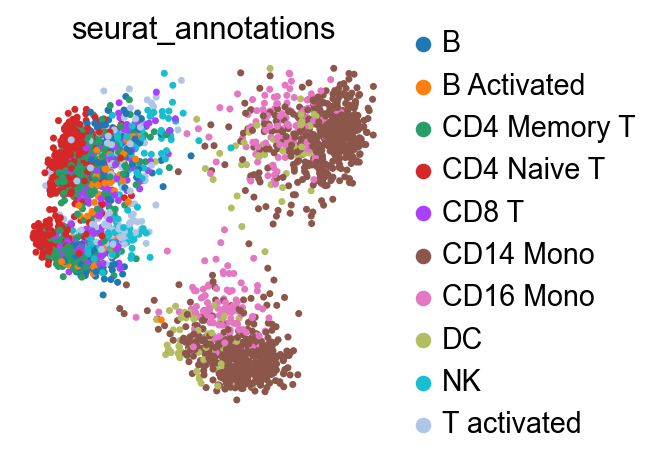

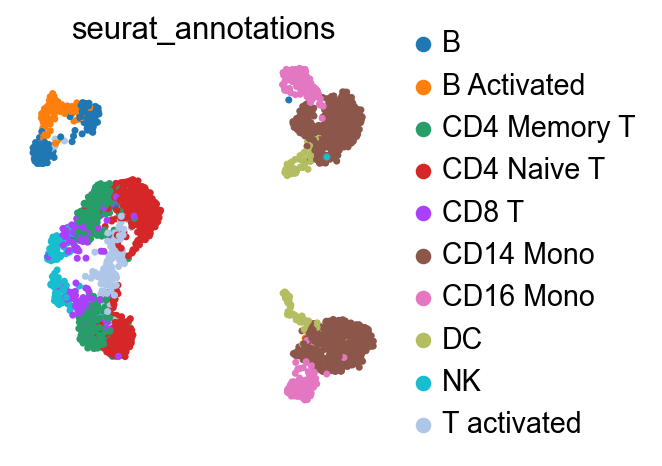

In [29]:
sc.pl.pca(adata, color=['seurat_annotations',
                                ],
                                frameon=False,
                                #ncols=2,
                                wspace=0.4)
sc.pl.umap(adata, color=['seurat_annotations',
                                ],
                                frameon=False,
                                #ncols=2,
                                wspace=0.4)

In [30]:
genesets = roma.read_gmt_to_dict(roma.gmt)
genesets.keys()

dict_keys(['HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'HALLMARK_HYPOXIA', 'HALLMARK_CHOLESTEROL_HOMEOSTASIS', 'HALLMARK_MITOTIC_SPINDLE', 'HALLMARK_WNT_BETA_CATENIN_SIGNALING', 'HALLMARK_TGF_BETA_SIGNALING', 'HALLMARK_IL6_JAK_STAT3_SIGNALING', 'HALLMARK_DNA_REPAIR', 'HALLMARK_G2M_CHECKPOINT', 'HALLMARK_APOPTOSIS', 'HALLMARK_NOTCH_SIGNALING', 'HALLMARK_ADIPOGENESIS', 'HALLMARK_ESTROGEN_RESPONSE_EARLY', 'HALLMARK_ESTROGEN_RESPONSE_LATE', 'HALLMARK_ANDROGEN_RESPONSE', 'HALLMARK_MYOGENESIS', 'HALLMARK_PROTEIN_SECRETION', 'HALLMARK_INTERFERON_ALPHA_RESPONSE', 'HALLMARK_INTERFERON_GAMMA_RESPONSE', 'HALLMARK_APICAL_JUNCTION', 'HALLMARK_APICAL_SURFACE', 'HALLMARK_HEDGEHOG_SIGNALING', 'HALLMARK_COMPLEMENT', 'HALLMARK_UNFOLDED_PROTEIN_RESPONSE', 'HALLMARK_PI3K_AKT_MTOR_SIGNALING', 'HALLMARK_MTORC1_SIGNALING', 'HALLMARK_E2F_TARGETS', 'HALLMARK_MYC_TARGETS_V1', 'HALLMARK_MYC_TARGETS_V2', 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'HALLMARK_INFLAMMATORY_RESPONSE', 'HALLMARK_XENOBIOTIC_METABOLISM', 'HAL

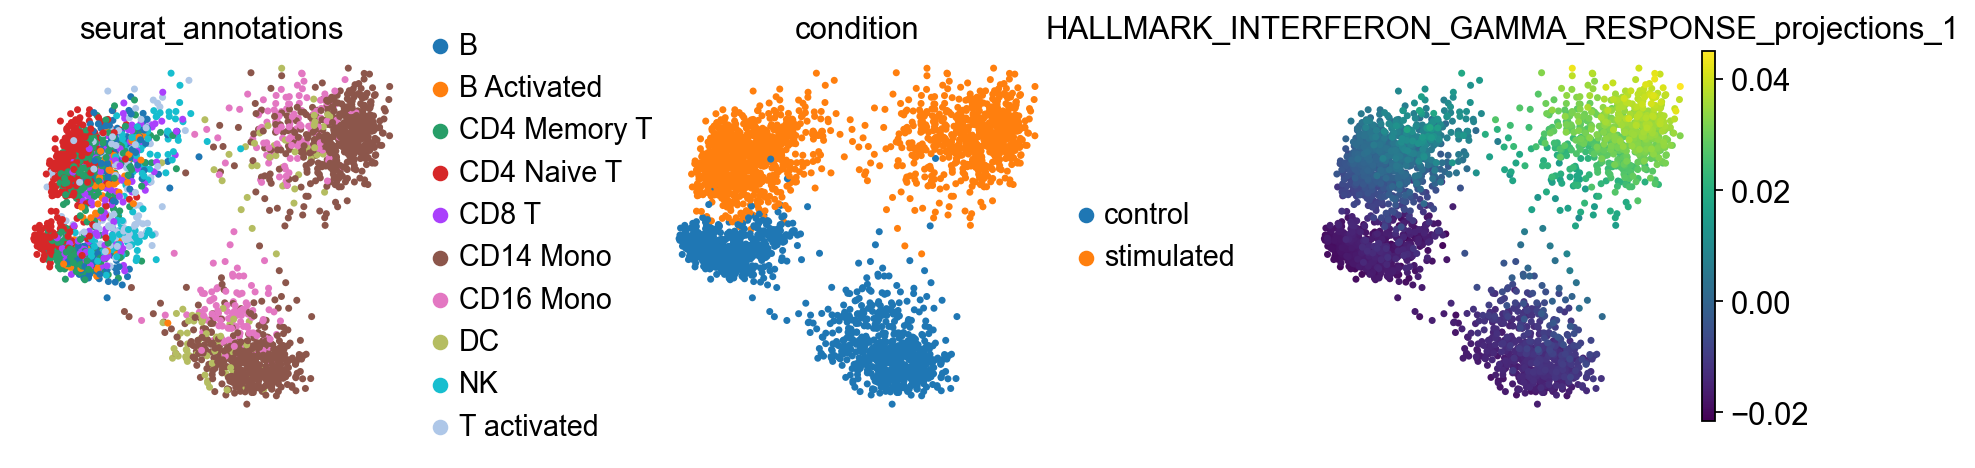

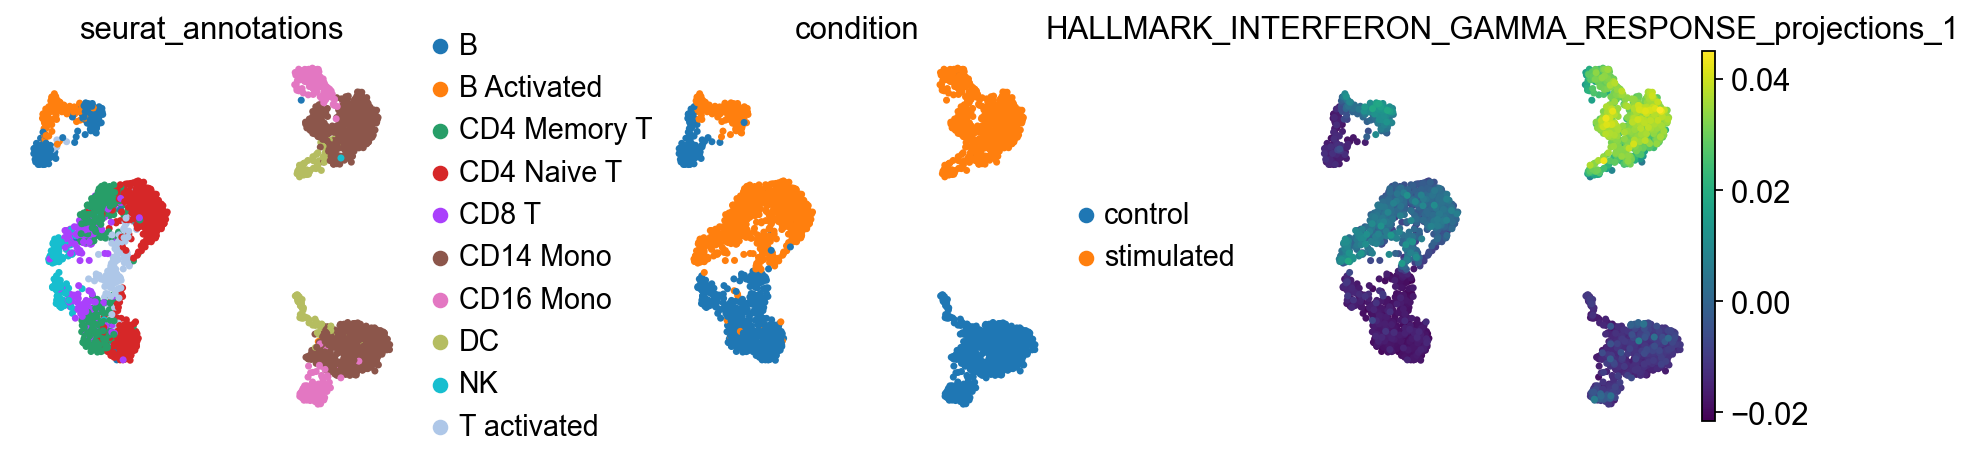

In [34]:
geneset_name = 'HALLMARK_INTERFERON_GAMMA_RESPONSE'


roma.adata.obs[f'{geneset_name}_projections_1'] = roma.adata.uns['ROMA'][f'{geneset_name}'].svd.components_[0]
roma.adata.obs[f'{geneset_name}_projections_1_reverse'] = -1 * roma.adata.uns['ROMA'][f'{geneset_name}'].svd.components_[0]

GeneScores = pd.DataFrame(roma.adata.uns['ROMA'][f'{geneset_name}'].projections_1,
                index=roma.adata.uns['ROMA'][f'{geneset_name}'].subsetlist,
                columns=[f'{geneset_name}'])

sc.pl.pca(adata, color=['seurat_annotations',
                                'condition',
                                f'{geneset_name}_projections_1'],
                                ncols=3,
                                wspace=0.5)

sc.pl.umap(adata, color=['seurat_annotations',
                         'condition',
                                f'{geneset_name}_projections_1'],
                                ncols=3,
                                wspace=0.5)

### top contributing genes

In [37]:
GeneScores.sort_values(by=geneset_name, ascending=False)

,HALLMARK_INTERFERON_GAMMA_RESPONSE
ISG15,85.189522
CXCL10,72.494965
IFITM3,47.420273
ISG20,47.004150
CCL2,43.896164
...,...
SOCS3,-1.331164
PIM1,-1.750599
CCL5,-2.078131
VAMP8,-2.914884


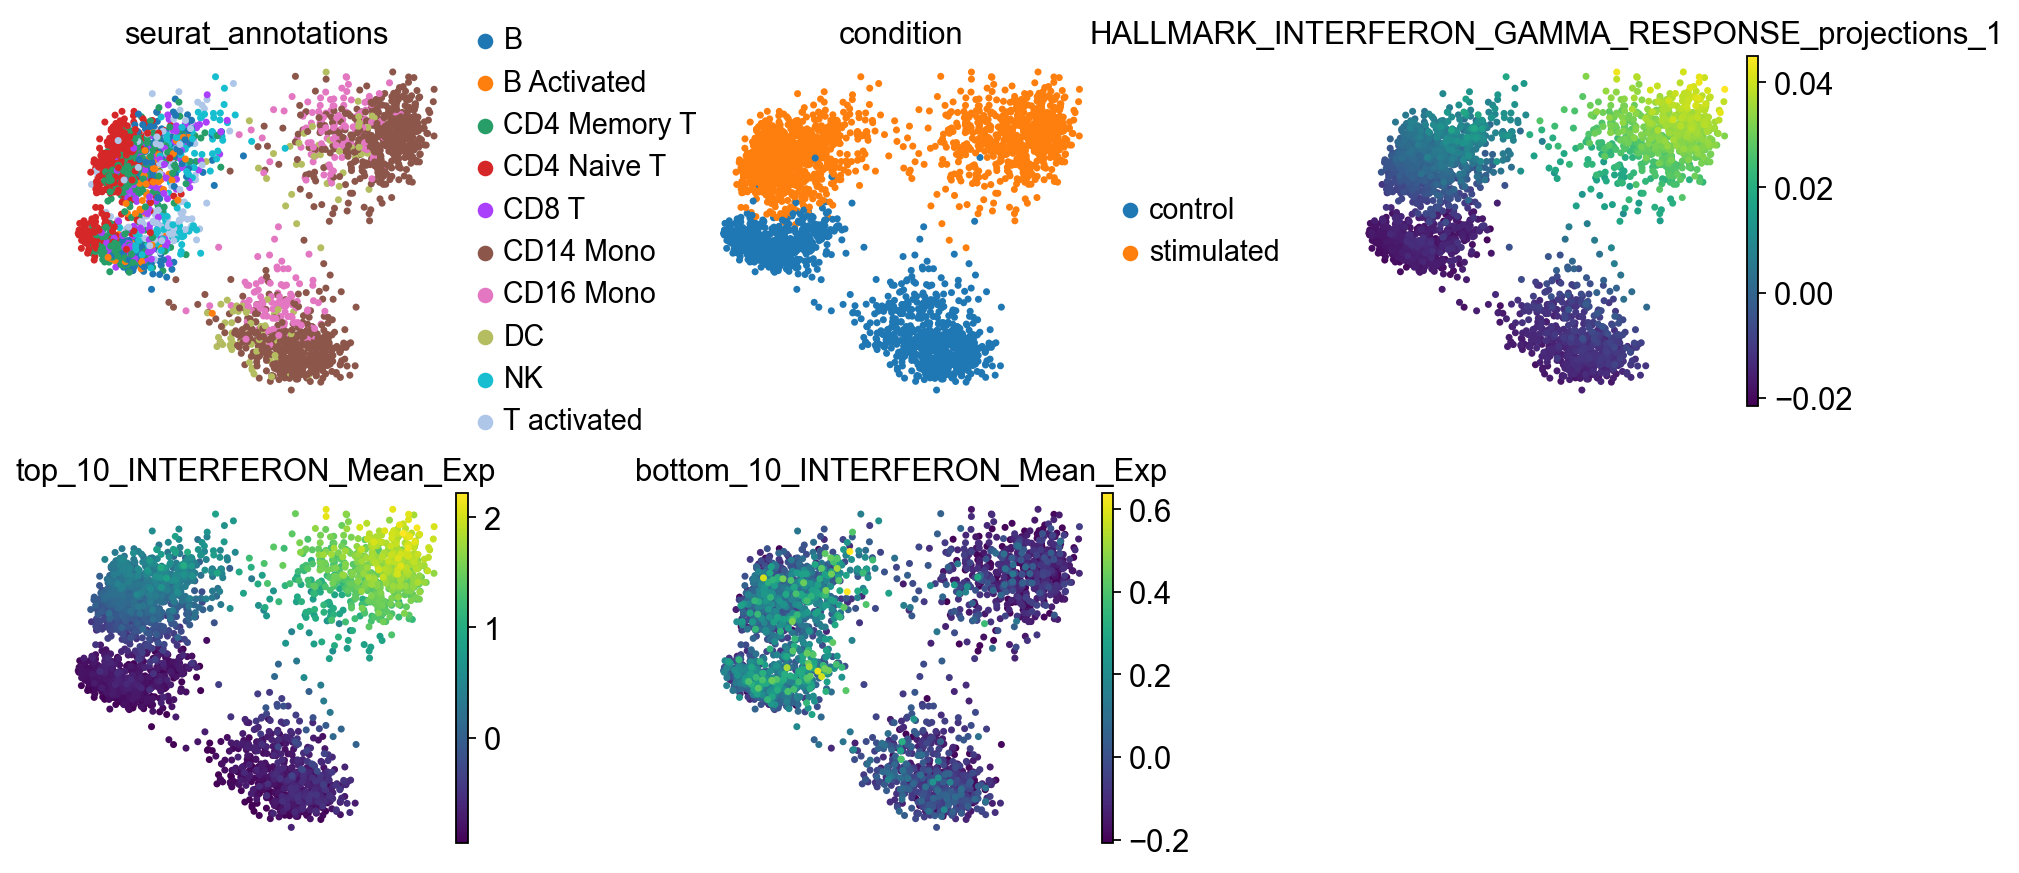

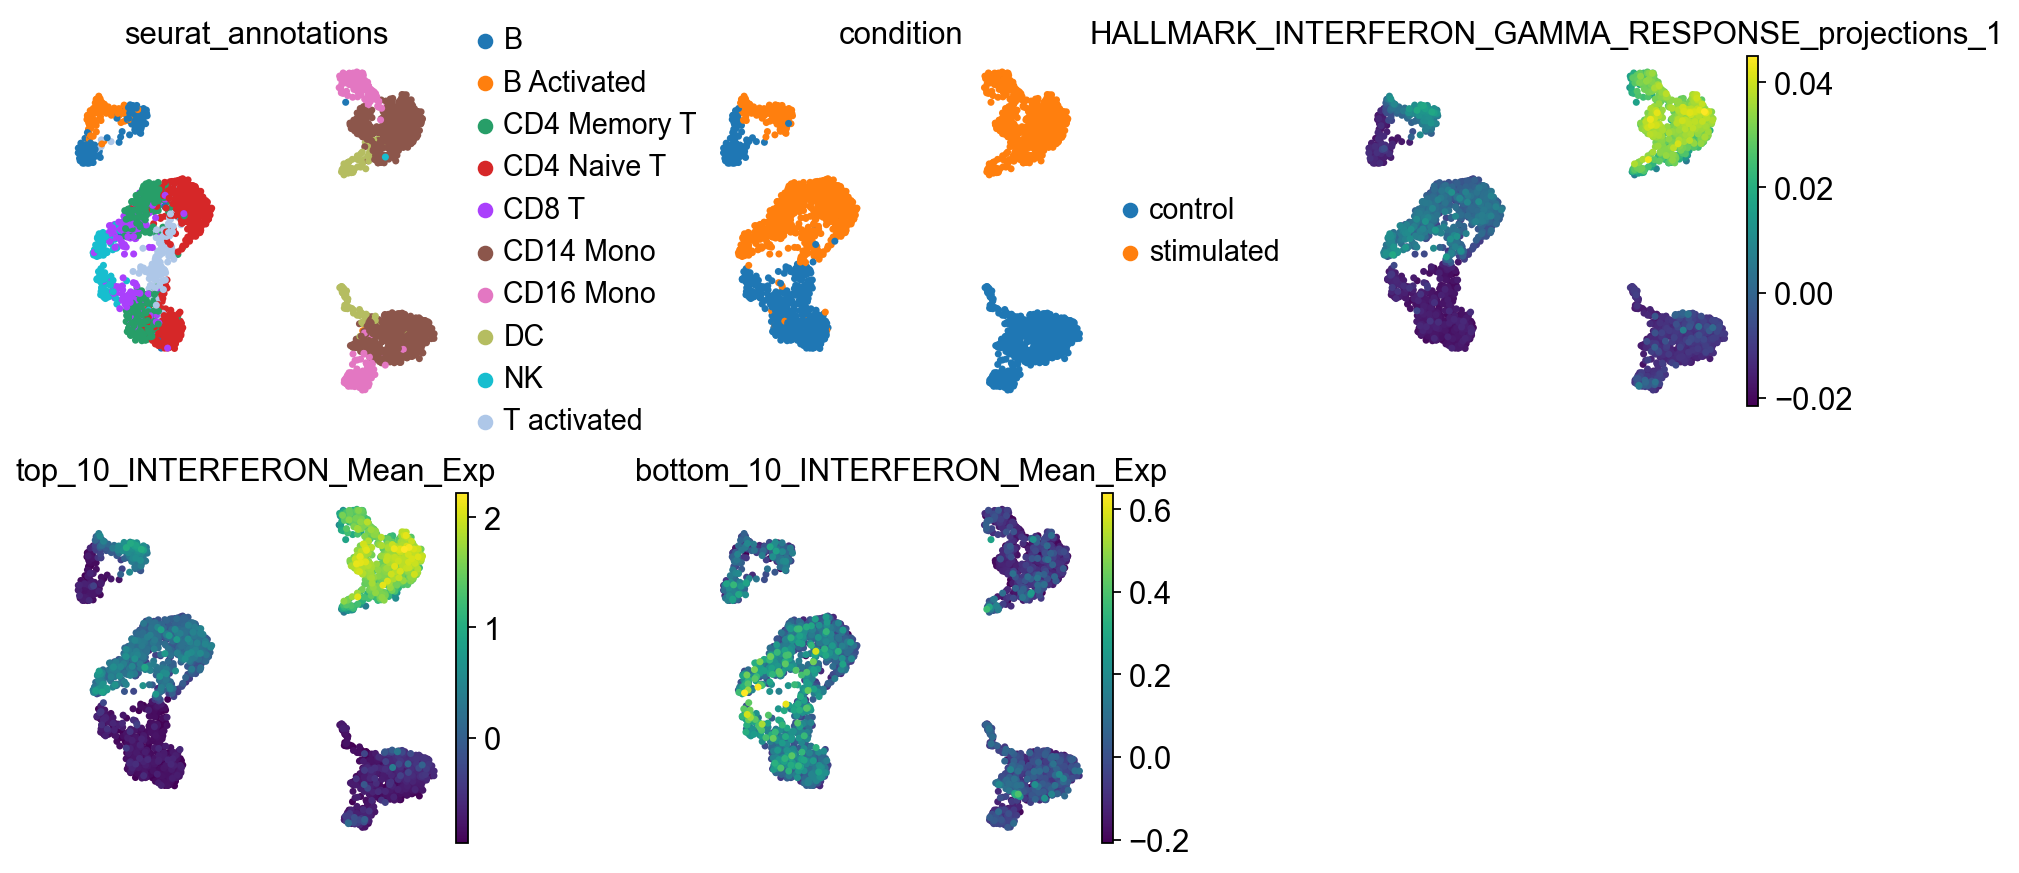

In [41]:
# number of top and bottom genes
n_top = 10
short_name = geneset_name.split('_')[1]

top_n = GeneScores.sort_values(by=f'{geneset_name}', ascending=False).head(n_top).index.tolist()
bottom_n = GeneScores.sort_values(by=f'{geneset_name}', ascending=False).tail(n_top).index.tolist()

top_mean_exp = roma.adata[:, top_n].X.mean(axis=1)
bottom_mean_exp = roma.adata[:, bottom_n].X.mean(axis=1)

roma.adata.obs[f'top_{n_top}_{short_name}_Mean_Exp'] = top_mean_exp
roma.adata.obs[f'bottom_{n_top}_{short_name}_Mean_Exp'] = bottom_mean_exp

sc.pl.pca(roma.adata, color=['seurat_annotations', 'condition',
                                f'{geneset_name}_projections_1',
                                f'top_{n_top}_{short_name}_Mean_Exp',
                                f'bottom_{n_top}_{short_name}_Mean_Exp'], 
                                
                                ncols=3,
                                wspace=0.5)

sc.pl.umap(roma.adata, color=['seurat_annotations', 'condition',
                                f'{geneset_name}_projections_1',
                                f'top_{n_top}_{short_name}_Mean_Exp',
                                f'bottom_{n_top}_{short_name}_Mean_Exp'], 
                                
                                ncols=3,
                                wspace=0.5)


### end